7등급의 새로운 공격을 잡기 위해서 0-6까지의 등급을 모두 정상이라 가정하고 Autoencoder 기반의 비지도 학습 기반으로 접근해보았습니다.

0-6까지의 등급을 학습 시킨후 Autoencoder로 복원 시켰을 떄 차이가 많이 나는 경우를 7등급으로 분류하도록 하였습니다.

Autoencoder 및 당양한 이상 탐지와 관련된 내용은 아래의 블로그를 참고하시면 도움이 될 것 같습니다.

https://hoya012.github.io/blog/anomaly-detection-overview-1/

In [1]:
import numpy as np
import pandas as pd
from numpy import vstack
import os
import gc
import tensorflow as tf
from keras.preprocessing import text, sequence
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from IPython.core.display import display, HTML
display(HTML("<style>.container { width: 100% !important; }</style>"))

전처리 방식은 nltk 라이브러리를 활용하여 영어 단어인 경우만 뽑아서 저장해놓은 것을 활용하였습니다.

전처리 코드는 추후에 다른 팀원이 코드 공유에 올리신 것을 확인해주시면 감사하겠습니다.

In [2]:
train=pd.read_csv('./data/onlyword2_train.csv')
test=pd.read_csv('./data/onlyword2_test.csv')
submission=pd.read_csv('./data/sample_submission.csv')

In [3]:
train.head()

,id,level,cut
0,0,0,collection connection error internal level liv...
1,1,0,action active audit code exception not primary...
2,2,0,collection connection error internal level liv...
3,3,0,collection connection error internal level liv...
4,4,1,arch audit bin cache date dev exit gid item ke...


In [4]:
train['cut'][0]

'collection connection error internal level living message name next node pool process share stack tick transport type warning'

In [5]:
train_text=list(train['cut'].astype(str))
train_level=np.array(train['level'])

# 토큰화

In [6]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(train_text)

In [7]:
sequences = tokenizer.texts_to_sequences(train_text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 2001 unique tokens.


log의 최대 길이 : 123
log의 평균 길이 : 14.981238


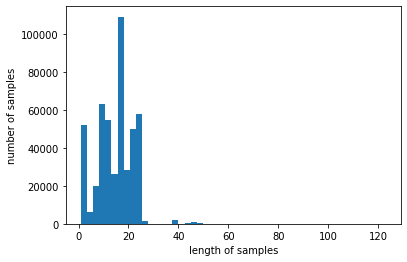

In [8]:
X_data = sequences
print('log의 최대 길이 : %d' % max(len(l) for l in X_data))
print('log의 평균 길이 : %f' % (sum(map(len, X_data))/len(X_data)))
plt.hist([len(s) for s in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [9]:
maxlen = 50

In [10]:
data = pad_sequences(sequences, maxlen=maxlen)

# 데이터 셋 준비
전체 데이터의 95%를 학습에 활용하고 나머지 5%의 데이터는 val 데이터와 합쳐서 threshold를 찾도록 활용하였습니다.

In [11]:
TEST_SIZE=0.05
RANDOM_SEED=42

X_train, X_test, y_train, y_test = train_test_split(data, train_level, test_size=TEST_SIZE, random_state=RANDOM_SEED)


In [12]:
X_train

array([[ 0,  0,  0, ...,  0,  0,  2],
       [ 0,  0,  0, ..., 27,  1,  8],
       [ 0,  0,  0, ..., 27,  1,  8],
       ...,
       [ 0,  0,  0, ..., 24,  1, 17],
       [ 0,  0,  0, ...,  1, 33, 17],
       [ 0,  0,  0, ..., 88, 40, 85]])

# 정규화
train 데이터셋을 기준은로 min_max 정규화를 해주었습니다.

In [13]:
X_train

array([[ 0,  0,  0, ...,  0,  0,  2],
       [ 0,  0,  0, ..., 27,  1,  8],
       [ 0,  0,  0, ..., 27,  1,  8],
       ...,
       [ 0,  0,  0, ..., 24,  1, 17],
       [ 0,  0,  0, ...,  1, 33, 17],
       [ 0,  0,  0, ..., 88, 40, 85]])

In [14]:
train_df = pd.DataFrame(X_train)
train_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,0,0,0,0,0,0,0,0,0,0,...,30,23,6,28,26,35,31,27,1,8
2,0,0,0,0,0,0,0,0,0,0,...,30,23,6,28,26,35,31,27,1,8
3,0,0,0,0,0,0,0,0,0,0,...,22,18,9,38,15,16,24,1,33,17
4,0,0,0,0,0,0,0,0,0,0,...,22,18,9,61,15,16,24,1,33,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449318,0,0,0,0,0,0,0,0,0,0,...,45,2,47,46,44,6,48,1,40,43
449319,0,0,0,0,0,0,0,0,0,0,...,0,0,124,60,53,102,72,126,43,127
449320,0,0,0,0,0,0,0,0,0,0,...,25,22,18,9,200,15,16,24,1,17
449321,0,0,0,0,0,0,0,0,0,0,...,22,18,9,38,15,16,24,1,33,17


In [15]:
columns = train_df.columns

In [16]:
TAG_MIN = train_df[columns].min()
TAG_MAX = train_df[columns].max()

In [17]:
def normalize(df):
    ndf = df.copy()
    for c in df.columns:
        if TAG_MIN[c] == TAG_MAX[c]:
            ndf[c] = df[c] - TAG_MIN[c]
        else:
            ndf[c] = (df[c] - TAG_MIN[c]) / (TAG_MAX[c] - TAG_MIN[c])
    return ndf

In [18]:
X_train = normalize(train_df[columns])
X_train

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0005
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015175,0.011717,0.003029,0.014056,0.013033,0.017518,0.015586,0.013650,0.000501,0.0035
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.015175,0.011717,0.003029,0.014056,0.013033,0.017518,0.015586,0.013650,0.000501,0.0035
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011128,0.009170,0.004543,0.019076,0.007519,0.008008,0.012066,0.000506,0.016525,0.0080
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011128,0.009170,0.004543,0.030622,0.007519,0.008008,0.012066,0.000506,0.016525,0.0080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
449318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.022762,0.001019,0.023725,0.023092,0.022055,0.003003,0.024133,0.000506,0.020030,0.0210
449319,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.062595,0.030120,0.026566,0.051051,0.036199,0.063701,0.021532,0.0630
449320,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.012645,0.011207,0.009086,0.004518,0.100251,0.007508,0.008044,0.012133,0.000501,0.0080
449321,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.011128,0.009170,0.004543,0.019076,0.007519,0.008008,0.012066,0.000506,0.016525,0.0080


train 데이터 셋에서 학습용으로 train, val로 한번 더 분할

In [19]:
TEST_SIZE=0.1
RANDOM_SEED=42

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [20]:
X_train.shape, X_val.shape

((404390, 50), (44933, 50))

# Autoencoder 모델

In [21]:
from keras import regularizers
def dnn(x):
    input_dim = x.shape[1]
    input = Input(shape=(input_dim, ))
    
    encode = Dense(x.shape[1], activation='relu', activity_regularizer=regularizers.l1(10e-5))(input)
    encode = Dense(x.shape[1]//2, activation='relu')(encode)
    decode = Dense(x.shape[1]//2, activation='relu')(encode)
    decode = Dense(x.shape[1], activation='relu')(decode)

    autoencoder = Model(input, decode)

    autoencoder.summary()
    
    return autoencoder

In [22]:
model = dnn(X_train)
model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=3)
modelpath = "./model/0,1_{epoch:02d}-{val_loss:.4f}.hdf5"
checkpointer = ModelCheckpoint(filepath=modelpath, monitor='val_loss', 
                               verbose=1, save_best_only=True)

epochs = 30
batch = 64

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                2550      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 25)                650       
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1300      
Total params: 5,775
Trainable params: 5,775
Non-trainable params: 0
_________________________________________________________________


In [23]:
# # fit
# history = model.fit(X_train, X_train,
#                      epochs=epochs, batch_size=batch,
#                      validation_data=(X_val, X_val), callbacks=[early_stopping, checkpointer])

# 모델 불러오기

In [24]:
model = load_model('./model/0,1_12-0.0001.hdf5')

# train 셋에서 분할해둔 test와 val의 3개 데이터를 합쳐서 결과확인 후 Threshold 설정

In [25]:
val_sample = pd.read_csv('./data/onlyword2_valid.csv')
val_sample

,word1,cut
0,type,arch audit dev exit gid key none null old prom...
1,oscap,account and any anyone assigned authentication...
2,Sep l,child kernel kill memory out probe process sac...


In [26]:
val_sample['cut']

0    arch audit dev exit gid key none null old prom...
1    account and any anyone assigned authentication...
2    child kernel kill memory out probe process sac...
Name: cut, dtype: object

In [27]:
val_smaple_data = tokenizer.texts_to_sequences(val_sample['cut'])
val_smaple_data = pad_sequences(val_smaple_data, maxlen=maxlen)

In [28]:
val_smaple_data.shape

(3, 50)

In [29]:
new_x = vstack([X_test, val_smaple_data])

In [30]:
len(new_x)

23652

In [31]:
new_df = pd.DataFrame(new_x)
new_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,0,0,0,0,0,0,0,0,...,155,113,50,156,153,143,1,73,163,51
1,0,0,0,0,0,0,0,0,0,0,...,0,65,66,71,59,67,68,64,69,70
2,0,0,0,0,0,0,0,0,0,0,...,30,23,6,28,26,35,31,27,1,8
3,0,0,0,0,0,0,0,0,0,0,...,30,23,6,28,26,35,31,27,1,8
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,78,80
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23647,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,72
23648,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,72
23649,0,0,0,0,0,0,0,0,0,0,...,220,244,1514,38,15,16,24,1,33,17
23650,1679,217,42,249,179,91,218,503,426,206,...,198,255,270,24,216,56,252,327,93,560


In [32]:
new_x = normalize(new_df[columns])
new_x

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.078402,0.057565,0.025240,0.078313,0.076692,0.071572,0.000503,0.036906,0.081622,0.0250
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.033113,0.033317,0.035643,0.029574,0.033534,0.034188,0.032356,0.034552,0.0345
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015175,0.011717,0.003029,0.014056,0.013033,0.017518,0.015586,0.013650,0.000501,0.0035
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015175,0.011717,0.003029,0.014056,0.013033,0.017518,0.015586,0.013650,0.000501,0.0035
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.039059,0.0395
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23647,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0355
23648,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0355
23649,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.111280,0.124300,0.764260,0.019076,0.007519,0.008008,0.012066,0.000506,0.016525,0.0080
23650,1.283639,0.129013,0.026923,0.129418,0.109816,0.056347,0.136506,0.299049,0.275194,0.126303,...,0.100152,0.129903,0.136295,0.012048,0.108271,0.028028,0.126697,0.165319,0.046570,0.2795


In [33]:
# 마지막 3개의 val 데이터는 레이블을 1로 변환 나머지는 0
y_val2 = np.zeros(len(y_test)+3)
y_val2[-3:] = 1

y_val2

array([0., 0., 0., ..., 1., 1., 1.])

# Autoencoder reconstrution error 계산

In [34]:
predictions = model.predict(new_x)

# MSE.
mse = np.mean(np.power(new_x - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

결과를 확인하였을 때 Trehsold가 0.05 기준으로 val 데이터 중에서 하나의 경우만 잘 잡아내는 것을 볼 수 있었습니다.
val 데이터 기준으로 어느정도 데이터를 분류하여 패턴이 비슷한 경우로 3가지를 나눠서 학습하였을 때는 모두 잘 잡아내는 것을 확인 할 수 있었습니다.
하지만 이 부분은 매턴 매칭 규정에 어긋나는 경우라고 생각되어 val 데이터 셋 중에서 한가지의 공격유형만 찾아낼 수 있었습니다.
3가지를 모두 Autoencoder 모델로 찾아내기에는 어려움이 있어서 최종 제출 모델에는 활용하지 않았습니다.

Text(0.5, 0, 'Data point index')

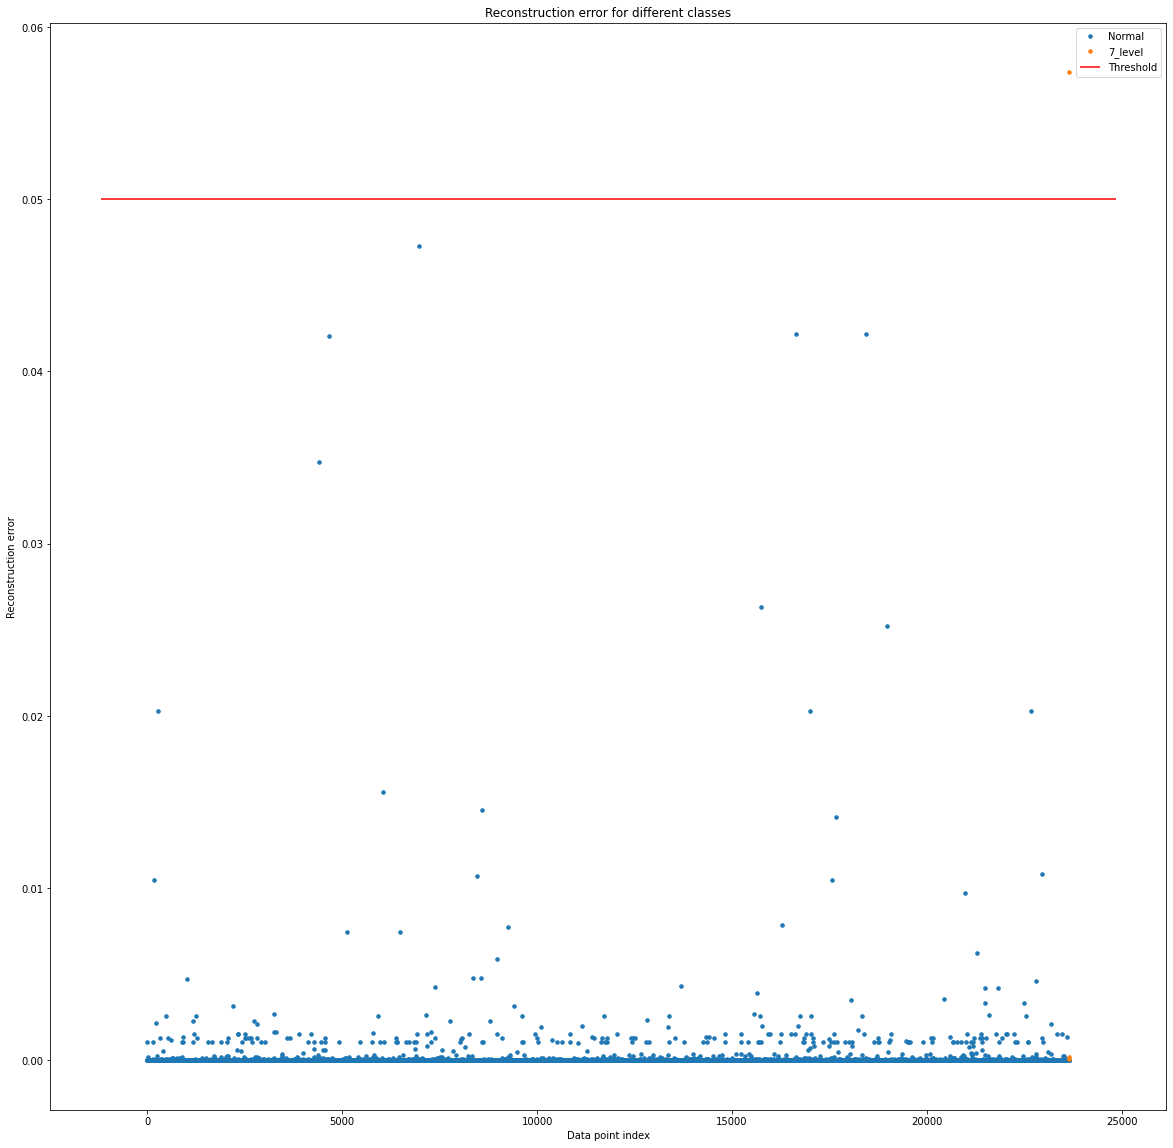

In [35]:
test_error_df = pd.DataFrame({'Reconstruction_error': list(error_df['reconstruction_error']),
                         'True_class': list(y_val2)})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "7_level" if name == 1 else "Normal")

ax.hlines(0.05, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

# 테스트 데이터 적용

In [36]:
test_data = tokenizer.texts_to_sequences(test['cut'].astype(str))
test_data = sequence.pad_sequences(test_data, maxlen=maxlen)

In [37]:
new_df = pd.DataFrame(test_data)
new_df

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0,0,142,161,148,154,145,36,147,183,...,156,153,31,27,143,1,73,163,8,182
1,0,0,0,0,0,0,0,0,0,0,...,30,23,6,28,26,35,31,27,1,8
2,0,0,0,0,0,0,0,0,0,0,...,18,9,198,38,15,16,24,1,33,17
3,0,0,0,0,0,0,0,0,0,0,...,30,23,6,28,26,35,31,27,1,8
4,0,0,0,0,0,0,0,0,0,0,...,3,25,22,18,9,15,16,24,1,17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418911,0,0,0,0,0,0,0,0,0,0,...,30,23,6,28,26,35,31,27,1,8
1418912,0,0,0,0,0,0,0,0,0,0,...,2,41,5,39,49,4,52,50,1,51
1418913,0,0,0,0,0,0,0,0,0,0,...,25,22,18,9,15,16,24,1,33,17
1418914,0,0,0,0,0,0,0,0,0,0,...,45,2,47,46,44,6,48,1,40,43


In [38]:
test_data  =  normalize(new_df[columns])
test_data 

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.0,0.0,0.091026,0.08368,0.090798,0.095356,0.090795,0.021403,0.094961,0.112201,...,0.078907,0.077942,0.015649,0.013554,0.071679,0.000501,0.036702,0.082406,0.004006,0.0905
1,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015175,0.011717,0.003029,0.014056,0.013033,0.017518,0.015586,0.013650,0.000501,0.0035
2,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.009105,0.004585,0.099950,0.019076,0.007519,0.008008,0.012066,0.000506,0.016525,0.0080
3,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015175,0.011717,0.003029,0.014056,0.013033,0.017518,0.015586,0.013650,0.000501,0.0035
4,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001517,0.012736,0.011106,0.009036,0.004511,0.007508,0.008044,0.012133,0.000501,0.0080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1418911,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.015175,0.011717,0.003029,0.014056,0.013033,0.017518,0.015586,0.013650,0.000501,0.0035
1418912,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.001012,0.020886,0.002524,0.019578,0.024561,0.002002,0.026144,0.025278,0.000501,0.0250
1418913,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.012645,0.011207,0.009086,0.004518,0.007519,0.008008,0.012066,0.000506,0.016525,0.0080
1418914,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.022762,0.001019,0.023725,0.023092,0.022055,0.003003,0.024133,0.000506,0.020030,0.0210


In [39]:
predictions = model.predict(test_data)

mse = np.mean(np.power(test_data  - predictions, 2), axis=1)
error_df = pd.DataFrame({'reconstruction_error': mse})

In [40]:
error_df

,reconstruction_error
0,1.506459e-03
1,4.049723e-07
2,1.023939e-05
3,4.049723e-07
4,8.673799e-06
...,...
1418911,4.049689e-07
1418912,5.410308e-07
1418913,6.140361e-06
1418914,5.458872e-07


# val 과 동일한 Threshold 적용

In [41]:
pred_y_test = [1 if e > 0.05 else 0 for e in (error_df['reconstruction_error'].values)]
pred_y_test = np.array(pred_y_test)
pred_y_test.shape

(1418916,)

Text(0.5, 0, 'Data point index')

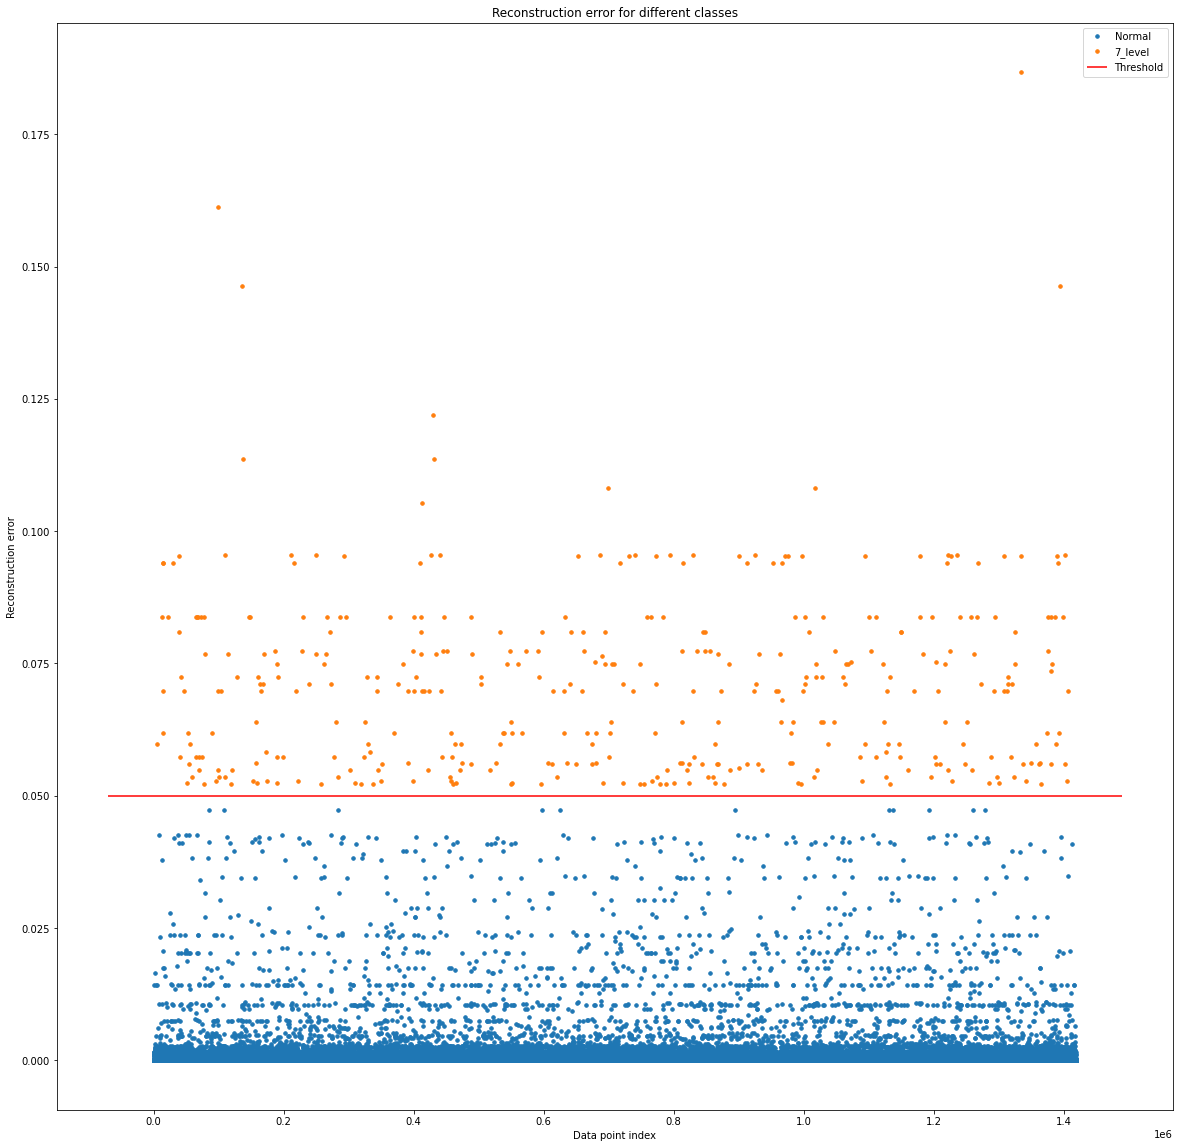

In [42]:
test_error_df = pd.DataFrame({'Reconstruction_error': list(error_df['reconstruction_error']),
                         'True_class': list(pred_y_test)})
groups = test_error_df.groupby('True_class')
fig, ax = plt.subplots(figsize=(20,20))

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "7_level" if name == 1 else "Normal")

ax.hlines(0.05, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()

plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")

In [43]:
test['predict'] = pred_y_test

In [44]:
test['predict'].value_counts()

0    1418528
1        388
Name: predict, dtype: int64

Autoencoder로 찾아낸 것이 모두 7공격이라고 확실할 수는 없지만 val에 있는 3가지 공격 패턴중에서 1가지를 잡아내었을 때 test 전체에서 약 400개 정도를 잡아내는 것을 확인할 수 있었습니다.